<a href="https://colab.research.google.com/github/ThOpaque/Food_Recognition/blob/main/YOLO_MNIST_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, time, datetime
from timeit import default_timer as timer
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%pip install torchinfo;
%pip install torchmetrics;
from torchmetrics import MeanSquaredError;
from torchinfo import summary;

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
### Choosing device between CPU or GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.has_mps:
    device=torch.device('mps')
else:
    device=torch.device('cpu')
    
print("\n------------------------------------")
print(f"Execute notebook on - {device} -")
print("------------------------------------\n")


------------------------------------
Execute notebook on - mps -
------------------------------------



In [3]:
class my_mnist_dataset(torch.utils.data.Dataset):
    def __init__(self, root:str, split:str=None, download:bool=False, S=6, sizeHW=75):
        assert split, "You have to specify the split."
        
        if split == "train":
            train = True
        elif split == "test":
            train = False
        
        self.dataset = torchvision.datasets.MNIST(root=root, train=train, download=download)
        
        self.cell_size = sizeHW / S
    
    def __len__(self):
        return len(self.dataset)

    def _numpy_pad_to_bounding_box(self, image, offset_height=0, offset_width=0, target_height=0, target_width=0):
        assert image.shape[:-1][0] <= target_height-offset_height, "height must be <= target - offset"
        assert image.shape[:-1][1] <= target_width-offset_width, "width must be <= target - offset"
        
        target_array = np.zeros((target_height, target_width, image.shape[-1]))

        for k in range(image.shape[0]):
            target_array[offset_height+k][offset_width:image.shape[1]+offset_width] = image[k]
        
        return target_array

    def _transform_pasting75(self, image, label):
        ### xmin, ymin of digit
        xmin = torch.randint(0, 48, (1,))
        ymin = torch.randint(0, 48, (1,))
        
        image = torchvision.transforms.ToTensor()(image)
        image = torch.reshape(image, (28,28,1,))
        image = torch.from_numpy(self._numpy_pad_to_bounding_box(image, ymin, xmin, 75, 75))
        image = image.permute(2, 0, 1) #(C,H,W)
        image = image.to(torch.float)
        
        xmin, ymin = xmin.to(torch.float), ymin.to(torch.float)

        xmax_bbox, ymax_bbox = (xmin + 28), (ymin + 28)
        xmin_bbox, ymin_bbox = xmin, ymin
        w_bbox = xmax_bbox-xmin_bbox
        h_bbox = ymax_bbox-ymin_bbox

        rw = w_bbox / 75
        rh = h_bbox / 75
        cx = (xmin + (w_bbox/2))/75
        cy = (ymin + (h_bbox/2))/75

        cx_rcell = cx % self.cell_size / self.cell_size
        cy_rcell = cy % self.cell_size / self.cell_size


        label_one_hot = F.one_hot(torch.as_tensor(label, dtype=torch.int64), 10)
        bbox_coord = torch.Tensor([cx_rcell, cy_rcell, rw, rh])

        return image, label_one_hot, bbox_coord

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image, one_hot_label, bbox_coord = self._transform_pasting75(self.dataset[idx][0], self.dataset[idx][1])
        
        return image, one_hot_label.to(torch.float), bbox_coord


In [4]:
def get_training_dataset(BATCH_SIZE=64):
    """
    Loads and maps the training split of the dataset using the custom dataset class. 
    """
    dataset = my_mnist_dataset(root="data", split="train", download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    return dataloader, len(dataset)

def get_validation_dataset(BATCH_SIZE = None):
    """
    Loads and maps the validation split of the datasetusing the custom dataset class. 
    """
    dataset = my_mnist_dataset(root="data", split="test", download=True)
    if BATCH_SIZE is None:
        BATCH_SIZE = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    return dataloader, len(dataset)

# instantiate the datasets
training_dataset, len_training_ds = get_training_dataset()
validation_dataset, len_validation_ds = get_validation_dataset()

In [5]:
class CNNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.l_relu = torch.nn.LeakyReLU(0.1)
    
    def forward(self, input):
        x = self.conv(input)
        x = self.bn(x)
        return self.l_relu(x)

In [6]:
class YoloMNIST(torch.nn.Module):
    def __init__(self, sizeHW, S, C, B):
        super(YoloMNIST, self).__init__()
        self.S, self.C, self.B = S, C, B
        self.sizeHW = sizeHW
        self.cell_size = self.sizeHW / self.S

        self.seq = torch.nn.Sequential()        
        self.seq.add_module(f"conv_1", CNNBlock(1, 32, stride=2, kernel_size=7, padding=2))
        self.seq.add_module(f"maxpool_1", torch.nn.MaxPool2d(2))
        self.seq.add_module(f"conv_3", CNNBlock(32, 128, stride=1, kernel_size=3, padding=0))
        self.seq.add_module(f"maxpool_2", torch.nn.MaxPool2d(2))
        self.seq.add_module(f"conv_5", CNNBlock(128, 64, stride=1, kernel_size=1, padding=0))
        self.seq.add_module(f"conv_4", CNNBlock(64, 128, stride=1, kernel_size=3, padding=0))
        self.seq.add_module(f"conv_6", CNNBlock(128, 128, stride=1, kernel_size=3, padding=1))
        
        self.fcs = self._create_fcs()

    def _size_output(self, sizeHW:int, kernel:int, stride:int, padding:int=0, isMaxPool:bool=False)->int:
        """
        Output size (width/height) of convolutional or maxpool layers.

        Args:
            sizeHW : int
                Image size (we suppose this is a square image)
            kernel : int
                Size of a square kernel
            stride : int
                Stride of convolution layer
            padding : int
                Padding of convolution layer
            isMaxPool : Bool, default is False.
                Specify if it is a Maxpool layer (True) or not (False). 

        Return:
            output_size : int
                Image output size after a convolutional or MaxPool layer.
        """ 
        if isMaxPool == True:
            output_size = int(sizeHW/2)
            print(output_size)
            return output_size
        if padding == 'same':
            output_size = sizeHW
            print(output_size)
            return output_size
        else:
            output_size = (sizeHW + 2 * padding - (kernel-1)-1)/stride
            output_size = int(output_size + 1)
            print(output_size)
            return output_size

    def _create_fcs(self):
        output = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(128 * self.S * self.S, 4096),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(4096, self.S * self.S * (self.C + self.B*5))
        )
        return output
    

    def forward(self, input:torch.Tensor)->tuple:
        """
        Forward pass.

        Args:
            input : torch.Tensor of shape (N, C, H, W)
                Batch of images.

        Return:
            box_coord : torch.Tensor of shape (N, 6, 6, 5)
                Contains xc_rcell, yc_rcell, rw, rh and the confidence number c
                over 6x6 grid cells.
            classifier : torch.Tensor of shape (N, 6, 6, 10)
                Contains the one-hot encoding of each digit number over
                6x6 grid cells.
        """     
        x = self.seq(input)
        x = self.fcs(x)
        x = x.view(x.size(0), self.S, self.S, self.B * 5 + self.C)
        box_coord = x[:,:,:,0:5]
        classifier = x[:,:,:,5:]
        return box_coord, classifier

In [12]:
class YoloLoss(torch.nn.Module):
    def __init__(self, lambd_coord:int, lambd_noobj:float, device:torch.device, S:int=6):
        super(YoloLoss, self).__init__()
        self.LAMBD_COORD = lambd_coord
        self.LAMBD_NOOBJ = lambd_noobj
        self.S = S
        self.device = device

    def _coordloss(self, pred_coord_rcell, true_coord_rcell):
        """
        Args : 
            pred_coord_rcell : torch.Tensor of shape (N, 2)
            true_coord_rcell : torch.Tensor of shape (N, 2)
        Returns :
            squared_error : torch.Tensor of shape (N)
        """
        xc_hat, yc_hat = pred_coord_rcell.permute(1,0)
        xc, yc = true_coord_rcell.permute(1,0)

        squared_error = torch.pow(xc - xc_hat,2) + torch.pow(yc - yc_hat,2)
        return squared_error

    def _sizeloss(self, pred_size, true_size):
        """
        Args :
            pred_size : torch.Tensor of shape (N, 2)
            true_size : torch.Tensor of shape (N, 2)
        Returns : 
            root_squared_error : torch.Tensor of shape (N)
        """
        rw_hat, rh_hat = pred_size.permute(1,0)
        rw, rh = true_size.permute(1,0)

        #sizes can't be negative
        rw_hat = rw_hat.clip(min=0)
        rh_hat = rh_hat.clip(min=0)

        root_squared_error_w = torch.pow(torch.sqrt(rw) - torch.sqrt(rw_hat),2)
        root_squared_error_h = torch.pow(torch.sqrt(rh) - torch.sqrt(rh_hat),2)
        root_squared_error = root_squared_error_w + root_squared_error_h
        return root_squared_error

    def _confidenceloss(self, pred_c, true_c):
        """
        Args :
            pred_c : torch.Tensor of shape (N)
            true_c : torch.Tensor of shape (N)
        Return :
            squared_error : torch.Tensor of shape (N)
        """
        squared_error = torch.pow(true_c - pred_c, 2)
        return squared_error

    def _classloss(self, pred_class, true_class):
        """
        Args :
            pred_class : torch.Tensor of shape (N, 10)
            true_class : torch.Tensor of shape (N, 10)
        Returns :
            squared_error : torch.Tensor of shape (N)
        """
        squared_error = torch.pow(true_class - pred_class, 2)
        return torch.sum(squared_error, dim=1)

    def forward(self, pred_box:torch.Tensor, true_box:torch.Tensor, pred_class:torch.Tensor, true_class:torch.Tensor):
        """
        Grid forward pass.

        Args:
            pred_box : torch.Tensor of shape (N, S, S, 5)
                Batch predicted outputs containing xc_rcell, yc_rcell, rw, rh,
                and confident number c for each grid cell.
            true_box : torch.Tensor of shape (N, S, S, 5)
                Groundtrue batch containing bbox values for each cell and
                c indicate if there is an object to detect or not (1/0).
            pred_class : torch.Tensor of shape (N, S, S, 10)
                Probability of each digit class in each grid cell
            true_class : torch.Tensor of shape (N, 10)
                one-hot vect of each digit

        Return:
            loss : float
                The batch loss value of the grid
        """
        BATCH_SIZE = len(pred_box)

        ### Initialization of the losses
        losses_list = ['loss_xy', 'loss_wh', 'loss_conf_obj', 'loss_conf_noobj', 'loss_class','isObject']
        losses = {key : torch.zeros(BATCH_SIZE).to(self.device) for key in losses_list}
        check_loss = []
        ### Compute the losses for all images in the batch
        for i in range(self.S):
            for j in range(self.S):
                ### Intersection over Union
                #IoU = self._intersection_over_union(pred_box[:,i,j], true_box[:,i,j])

                ### bbox coordinates
                xy_hat = pred_box[:,i,j,:2]
                xy = true_box[:,i,j,:2]
                wh_hat = pred_box[:,i,j,2:4]
                wh = true_box[:,i,j,2:4]
                
                ### confidence numbers
                pred_c = pred_box[:,i,j,4]# * IoU
                true_c = true_box[:,i,j,4]

                ### objects to detect
                isObject = true_c.to(torch.bool)
                isNoObject = torch.logical_not(true_c) #(~bool) doesn't work on MPS device

                ### sum the losses over the grid
                losses['isObject'] += isObject
                losses['loss_xy'] += isObject * self._coordloss(xy_hat, xy)
                check_loss.append(losses['loss_xy'])
                losses['loss_wh'] += isObject * self._sizeloss(wh_hat, wh)
                losses['loss_conf_obj'] += isObject * self._confidenceloss(pred_c, true_c)
                losses['loss_conf_noobj'] += isNoObject * self._confidenceloss(pred_c, true_c)
                losses['loss_class'] += isObject * self._classloss(pred_class[:,i,j], true_class)
        


        ### Yolo_v1 loss over the batch, shape : (BATCH_SIZE)
        loss = self.LAMBD_COORD * losses['loss_xy'] \
                + self.LAMBD_COORD * losses['loss_wh'] \
                + losses['loss_conf_obj'] \
                + self.LAMBD_NOOBJ * losses['loss_conf_noobj'] \
                + losses['loss_class']


        assert torch.isnan(torch.sum(losses['loss_conf_obj']))==False, "La loss {} est devenu nan".format('loss_conf_obj')
        assert torch.isnan(torch.sum(losses['loss_conf_noobj']))==False, "La loss {} est devenu nan".format('loss_conf_noobj')
        assert torch.isnan(torch.sum(losses['loss_class']))==False, "La loss {} est devenu nan".format('loss_class')
        assert torch.isnan(torch.sum(losses['isObject']))==False, "La loss {} est devenu nan".format('isObject')
        assert torch.isnan(torch.sum(losses['loss_wh']))==False, "La loss {} est devenu nan".format('loss_wh')
        assert torch.isnan(torch.sum(losses['loss_xy']))==False, "La loss {} est devenu nan".format('loss_xy')


        loss = torch.sum(loss) / BATCH_SIZE

        return check_loss, losses, loss
        


In [8]:
def bbox2Tensor(bbox:torch.Tensor, S:int=6, sizeHW:int=75, device=torch.device('cpu'))->torch.Tensor:
    """
    Constructs en Tensor and puts bbox values in the corresponding i,j grid cell.

    Args :
        bbox : torch.Tensor of shape (N,4)
            Contains bbox values xc_rcell, yc_rcell, rw and rh.
        S : int, default is 6
            Size of the grid.
        sizeHW : int, default is 75
            Size of the image.

    Return :
        bbox_t : torch.Tensor of shape (N, S, S, 5)
            Tensor containing all 4 bbox values in the corresponding i,j grid
            cell position i.e. in the i,j position where an object should be
            detected.
    """
    N = len(bbox)
    bbox_t = torch.zeros(N,S,S,5).to(device)
    cell_size = sizeHW/S

    xc_rcell, yc_rcell, rw, rh = bbox.permute(1,0).to(device)
    xc = xc_rcell * cell_size - (1/cell_size) * (xc_rcell/cell_size).to(torch.int32)
    yc = yc_rcell * cell_size - (1/cell_size) * (yc_rcell/cell_size).to(torch.int32)

    N_range = torch.arange(N)
    lines = (yc * S).to(torch.long)
    columns = (xc * S).to(torch.long)
    bbox_t[N_range, lines, columns] = torch.stack((xc_rcell, yc_rcell, rw, rh, torch.ones(N))).permute(1,0)
    
    return bbox_t.to(device)

In [31]:
device = torch.device('cpu')
loss_yolo = YoloLoss(lambd_coord=5, lambd_noobj=0.5, S=6, device=device)
learning_rate = 0.00001

In [10]:
learning_rate = 0.001
BATCH_SIZE = 64

model_MNIST = YoloMNIST(sizeHW=75, S=6, C=10, B=1)
model_MNIST = model_MNIST.to(device)
optimizer = torch.optim.Adam(params=model_MNIST.parameters(), lr=learning_rate, weight_decay=0.0005)
loss_yolo = YoloLoss(lambd_coord=5, lambd_noobj=0.5, S=6, device=device)

# print(optimizer)
#summary(model_MNIST, input_size = (BATCH_SIZE,1,75,75))

In [32]:
delta_time = datetime.timedelta(hours=1)
timezone = datetime.timezone(offset=delta_time)

t = datetime.datetime.now(tz=timezone)
str_t = '{:%Y-%m-%d %H:%M:%S}'.format(t)
print(f"[START] : {str_t} :")
print(f"[Training on] : {str(device).upper()}")

EPOCHS = 10
size_grid = 6
batch_loss_list = []
model_MNIST = model_MNIST.to(device)
check = []

for epoch in range(EPOCHS) : 
    begin_time = timer()
    epochs_loss = 0.
    
    print("-"*20)
    str_t = '{:%Y-%m-%d %H:%M:%S}'.format(t)
    print(" "*5 + f"{str_t} : EPOCH {epoch+1}/{EPOCHS}")
    print("-"*20)

    model_MNIST.train()
    for batch, (img, labels, bbox_true) in enumerate(training_dataset):
        loss = 0
        begin_batch_time = timer()
        img, labels, bbox_true = img.to(device), labels.to(device), bbox_true.to(device)
        
        ### turn bbox into NxSxSx5 tensor
        bbox_true_6x6 = bbox2Tensor(bbox_true).to(device)
        
        ### clear gradients
        optimizer.zero_grad()
        
        ### compute predictions
        bbox_preds, label_preds = model_MNIST(img)
        
        ### compute losses over each grid cell for each image in the batch
        check_xy, losses, loss = loss_yolo(bbox_preds, bbox_true_6x6, label_preds, labels)
        check.append(check_xy)
    
        ### compute gradients
        loss.backward()
        
        ### Weight updates
        optimizer.step()
        
        ######### print part #######################
        current_loss = loss.item()
        batch_loss_list.append(current_loss)
        epochs_loss = epochs_loss + current_loss

        if batch+1 <= len_training_ds//BATCH_SIZE:
            current_training_sample = (batch+1)*BATCH_SIZE
        else:
            current_training_sample = (batch)*BATCH_SIZE + len_training_ds%BATCH_SIZE
        
        if (batch) == 0 or (batch+1)%100 == 0 or batch == len_training_ds//BATCH_SIZE:
            print(f" --- Image : {current_training_sample}/{len_training_ds}",\
                    f" : loss = {current_loss:.5f}")
            print(f"xy_coord training loss for this batch : {torch.sum(losses['loss_xy']) / len(img):.5f}")
            print(f"wh_sizes training loss for this batch : {torch.sum(losses['loss_wh']) / len(img):.5f}")
            print(f"confidence with object training loss for this batch : {torch.sum(losses['loss_conf_obj']) / len(img):.5f}")
            print(f"confidence without object training loss for this batch : {torch.sum(losses['loss_conf_noobj']) / len(img):.5f}")
            print(f"class proba training loss for this batch : {torch.sum(losses['loss_class']) / len(img):.5f}")
            print('\n')
            if batch == (len_training_ds//BATCH_SIZE):
                print(f"Total elapsed time for training : {datetime.timedelta(seconds=timer()-begin_time)}")
                print(f"Mean training loss for this epoch : {epochs_loss / len(training_dataset):.5f}")

[START] : 2022-08-26 17:58:48 :
[Training on] : CPU
--------------------
     2022-08-26 17:58:48 : EPOCH 1/10
--------------------
 --- Image : 64/60000  : loss = 0.09439
xy_coord training loss for this batch : 0.00019
wh_sizes training loss for this batch : 0.00013
confidence with object training loss for this batch : 0.03031
confidence without object training loss for this batch : 0.04939
class proba training loss for this batch : 0.03779


 --- Image : 6400/60000  : loss = 0.08519
xy_coord training loss for this batch : 0.00099
wh_sizes training loss for this batch : 0.00031
confidence with object training loss for this batch : 0.02470
confidence without object training loss for this batch : 0.05698
class proba training loss for this batch : 0.02549


 --- Image : 12800/60000  : loss = 0.10395
xy_coord training loss for this batch : 0.00023
wh_sizes training loss for this batch : 0.00018
confidence with object training loss for this batch : 0.03329
confidence without object trainin

In [34]:
torch.save(model_MNIST.state_dict(), "yolo_mnist_model_Xepochs.pt")

In [35]:
def relative2absolute(bbox_relative:torch.Tensor, SIZEHW=75, S=6)->torch.Tensor:
    """
    Turns bounding box relative to cell coordinates into absolute coordinates 
    (pixels). Used to calculate IoU. 

    Args:
        bbox_relative : torch.Tensor of shape (N, 4)
            Bounding box coordinates to convert.
    Return:
        bbox_absolute : torch.Tensor of shape (N, 4)
    """
    CELL_SIZE = SIZEHW/S

    cx_rcell, cy_rcell, rw, rh = bbox_relative[:,:4].permute(1,0)
    
    ### xc,yc centers relative to the frame coordinates
    cx = cx_rcell * CELL_SIZE - (1/CELL_SIZE) * (cx_rcell/CELL_SIZE).to(torch.int32)
    cy = cy_rcell * CELL_SIZE - (1/CELL_SIZE) * (cy_rcell/CELL_SIZE).to(torch.int32)

    ### xc,yc centers absolute coordinates
    cx_abs = SIZEHW * cx
    cy_abs = SIZEHW * cy

    ### x,y absolute positions 
    x_min = cx_abs - (SIZEHW * (rw/2))
    y_min = cy_abs - (SIZEHW * (rh/2))
    x_max = cx_abs + (SIZEHW * (rw/2))
    y_max = cy_abs + (SIZEHW * (rh/2))

    bbox_absolute = torch.stack((x_min, y_min, x_max, y_max), dim=-1)
    return bbox_absolute

def intersection_over_union(pred_box:torch.Tensor, true_box:torch.Tensor)->torch.Tensor:
    """
    Intersection over Union method.

    Args:
        pred_box : torch.Tensor of shape (N, 5)
            Predicted bounding boxes of a batch, in a given cell.
        true_box : torch.Tensor of shape (N, 5)
            Ground truth bounding boxes of a batch, in a given cell.

    Return:
        iou : float
            Number between 0 and 1 where 1 is a perfect overlap.
    """
    ### Convert cell reltative coordinates to absolute coordinates
    pred_box = relative2absolute(pred_box)
    true_box = relative2absolute(true_box)   
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = pred_box.permute(1,0)
    xmin_true, ymin_true, xmax_true, ymax_true = true_box.permute(1,0)

    ### There is no object if all coordinates are zero
    isObject = xmin_true + ymin_true + xmax_true + ymax_true
    isObject = isObject.to(torch.bool)

    smoothing_factor = 1e-10

    ### x, y overlaps btw pred and groundtrue
    xmin_overlap = torch.maximum(xmin_pred, xmin_true)
    xmax_overlap = torch.minimum(xmax_pred, xmax_true)
    ymin_overlap = torch.maximum(ymin_pred, ymin_true)
    ymax_overlap = torch.minimum(ymax_pred, ymax_true)
    
    ### Pred and groundtrue areas
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    ### Compute intersection area, union area and IoU
    overlap_area = torch.maximum((xmax_overlap - xmin_overlap), torch.Tensor([0]).to(device)) * torch.maximum((ymax_overlap - ymin_overlap), torch.Tensor([0]).to(device))
    union_area = (pred_box_area + true_box_area) - overlap_area
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)
    
    ### Set IoU to zero when there is no coordinates (i.e. no object)
    iou = iou * isObject

    return iou   


In [113]:
S=6
for (img, labels, bbox_true) in validation_dataset:
    img, labels, bbox_true = img.to(device), labels.to(device), bbox_true.to(device)
    model_MNIST.eval()
    with torch.no_grad():
        ### prediction
        bbox_preds, label_preds = model_MNIST(img)

        ### (N,4) -> (N, S, S, 5)
        bbox_true_6x6 = bbox2Tensor(bbox_true).to(device)

        ### keeping only cells (i,j) with an object 
        cells_with_obj = bbox_true_6x6.nonzero()[::5]
        N, cells_i, cells_j, _ = cells_with_obj.permute(1,0)

        ### MSE along bbox coordinates and sizes in the cells containing an object
        mse_box = (1/len(img)) * torch.sum(torch.pow(bbox_true - bbox_preds[N, cells_i, cells_j,:4],2))
        
        ### confidence score accuracy : sum of the all grid confidence scores
        ### pred confidence score is confidence score times IoU.
        mse_confidence_score = torch.zeros(len(img))
        for i in range(S):
            for j in range(S):
                iou = intersection_over_union(bbox_true_6x6[:,i,j], bbox_preds[:,i,j])
                mse_confidence_score += torch.pow(bbox_true_6x6[:,i,j,-1] - bbox_preds[:,i,j,-1] * iou,2)
        
        mse_confidence_score = (1/(len(img))) * torch.sum(mse_confidence_score)

        ### applied softmax to class predictions and compute accuracy
        softmax_pred_classes = torch.softmax(label_preds[N, cells_i, cells_j], dim=1)
        classes_acc = (1/len(img)) * torch.sum(torch.argmax(labels, dim=1) == torch.argmax(softmax_pred_classes, dim=1))

print(f"MSE BOX : {mse_box.item():.5f}")
print(f"MSE confidence score : {mse_confidence_score.item():.5f}")
print(f"class acc : {classes_acc.item()*100:.2f}%")

MSE BOX : 0.00018
MSE confidence score : 0.21276
class acc : 99.04%


In [222]:
############### Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
################################################################################

In [262]:
def draw_ONE_bounding_box_on_image(image, ymin:int, xmin:int, ymax:int, xmax:int, 
                               color:str='red', thickness:int=1, display_str:bool=None):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  
  left, right, top, bottom = xmin, xmax, ymin, ymax
  
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

In [334]:
def draw_bounding_boxes_on_image(image, boxes_dict:dict, color_list:list=[], 
                                 thickness:int=1, display_str_list:tuple=()):
  """Draws bounding boxes on image.

  Args:
    image: PIL.Image.
    boxes: numpy array of shape (N,4)
      Contains (ymin, xmin, ymax, xmax). The coordinates are absolute.
    color: list, default is empty
      Color to draw bounding box.
    thickness: int, default value is 4
      Line thickness.
    display_str_list: tuple
      A list of strings for each bounding box.
                           
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  for key in boxes_dict.keys():
    if key == "true_bbox":
      color = color_list[0]
      thickness = 4
    else : 
      color = color_list[1]
      thickness = 1

    boxes = np.asarray(boxes_dict[key])
    boxes_shape = boxes.shape
    if not boxes_shape:
      return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
      raise ValueError('Input must be of size [N, 4]')
    
    for i in range(boxes_shape[0]):
      draw_ONE_bounding_box_on_image(image, 
                                    boxes[i, 1], boxes[i, 0], 
                                    boxes[i, 3], boxes[i, 2], 
                                    color=color, thickness=thickness)
                                    #, thickness, display_str_list[i])
    
                              

In [335]:
def draw_bounding_boxes_on_image_array(image:np.ndarray, boxes:dict, color:list=[], 
                                       thickness:int=1, display_str_list:tuple=()):
  """Draws bounding boxes on image (numpy array).

  Args:
    image: a numpy array object.
    ####boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].######
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: a list of strings for each bounding box.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new("RGBA", image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
  return np.array(rgbimg)

In [336]:
################################################################################
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, title, nb_sample=10):
  """Utility to display a row of digits with their predictions.

  Args:
    digits : np.ndarray of shape (N,75,75,1)
        Raw image with normalized pixel values (from 0 to 1)
    predictions : np.ndarray of shape (N,)
        Predicted label with the same shape as labels
    labels : np.ndarray of shape (N,)
        Labels of the digits (from 0 to 9)
    pred_bboxes : np.ndarray of shape (N, 4) ??
        Predicted bboxes locations
    bboxes : np.ndarray of shape (N, 4)
        Ground true bboxe locations
    iou : list of shape (N,)
        IoU of each bboxes
    title : str
        Figure's title
  """
  iou_threshold = 0.6
  nb_sample = 10
  indexes = np.random.choice(len(predictions), size=nb_sample)
  
  n_digits = digits[indexes].numpy()
  # Rescale pixel values to un-normed values (from 0 -black- to 255 -white-)
  n_digits = n_digits * 255.0
  n_digits = n_digits.reshape(nb_sample, 75, 75)
  
  n_predictions = predictions[indexes]
  # Argmax of one-hot vectors. Shape : (N,S,S,10) -> (N,S,S)
  n_predictions = torch.argmax(torch.softmax(n_predictions, dim=-1), dim=-1).numpy()
  
  ### shape : (N, S, S, 5)
  n_pred_bboxes = pred_bboxes[indexes]

  ### shape : (N, 4)
  n_bboxes_rel = bboxes[indexes]
  n_bboxes = relative2absolute(torch.as_tensor(n_bboxes_rel)).numpy()
  # n_bboxes = n_bboxes_rel/75

  # Set plot config
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  
  bboxes_to_plot = {"true_bbox":[], "pred_bbox":[]}
  for i in range(nb_sample):
    bboxes_to_plot["pred_bbox"] = []
    bboxes_to_plot["true_bbox"] = []
    
    for cell_i in range(6):
      for cell_j in range(6):
        n_pred_bboxes_ij = n_pred_bboxes[:, cell_i, cell_j, :4]
        
        # n_iou = intersection_over_union(n_pred_bboxes_ij, n_bboxes_rel)
        
        # n_predictions_ij = n_predictions[:, cell_i, cell_j]

        n_pred_bboxes_ij = relative2absolute(n_pred_bboxes_ij).numpy()
        
        bboxes_to_plot["pred_bbox"].append(n_pred_bboxes_ij[i])
    
    bboxes_to_plot["true_bbox"].append(n_bboxes[i])
    
    ax = fig.add_subplot(1, nb_sample, i+1)
    img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes = bboxes_to_plot, color=["white", "red"])#, display_str_list=["true", "pred"])
    # img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes = np.asarray(bboxes_to_plot["pred_bbox"]), color="red")#, display_str_list=["true", "pred"])
# plt.xlabel(n_predictions[i])
    plt.xticks([])
    plt.yticks([])

# if n_predictions[i] != n_labels[i]:
#   ax.xaxis.label.set_color('red')

    plt.imshow(img_to_draw)
 
# if len(iou) > i :
# color = "black"
# if (n_iou[i] < iou_threshold):
#   color = "red"
# ax.text(0.2, -0.3, "iou: %s" %(n_iou[i]), color=color, transform=ax.transAxes)

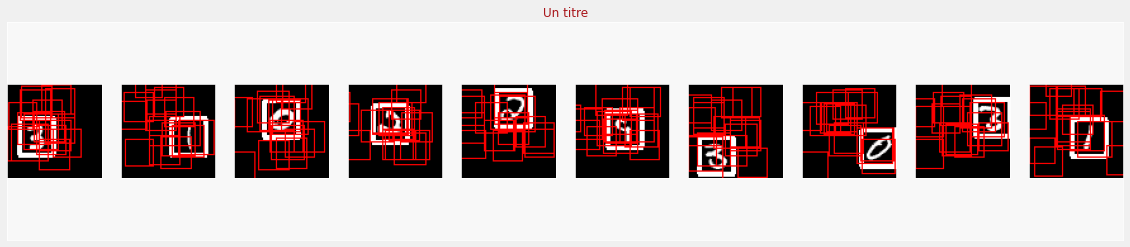

In [337]:
display_digits_with_boxes(img, label_preds, labels, bbox_preds, bbox_true, "Un titre")